In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
from sklearn.metrics import f1_score
from itertools import product
import matplotlib.pyplot as plt

In [2]:
PATH = 'percentages.csv'

In [3]:
df = pd.read_csv(PATH)
df.head()

,text_ids,labels,annotators_percentage,llama_percentage,mistral_percentage
0,medium-17,1,0.888889,0.333333,1.000000
1,medium-17,0,0.666667,0.000000,0.222222
2,medium-17,1,0.111111,1.000000,0.888889
3,medium-17,1,0.444444,0.888889,0.333333
4,medium-17,1,0.444444,0.000000,0.444444


In [4]:
labels = df['labels']
ann_percentage = df['annotators_percentage']
llama_percentage = df['llama_percentage']
mistral_percentage = df['mistral_percentage']

In [5]:
def divide(array):
    borders = [(0, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.1)]
    
    values = []
    for range in borders:
        v = []
        for x in array:
            if (x >= range[0]) & (x < range[1]):
                v.append(x)    
        values.append(v)
        
    return values

In [6]:
ann_divided = divide(ann_percentage)
llama_divided = divide(llama_percentage)
mistral_divided = divide(mistral_percentage)

In [7]:
def numbers_matrix(annotators, llm):
    matrix = []
    for x in llm:
        l1 = len(x)
        row = []
        for y in annotators:
            l2 = len(y)
            row.append(l1+l2)
        matrix.append(row)
    return np.array(matrix)

In [8]:
bins = {
    0: '50',
    1: '60',
    2: '70',
    3: '80',
    4: '90',
    5: '100'
}

print('Annotators')
for key in range(len(ann_divided)):
    print(bins[key], ': ', len(ann_divided[key]))
print('-'*80)

print('Llama')
for key in range(len(llama_divided)):
    print(bins[key], ': ', len(llama_divided[key]))
print('-'*80)

print('Mistral')
for key in range(len(mistral_divided)):
    print(bins[key], ': ', len(mistral_divided[key]))
print('-'*80)

Annotators
50 :  67
60 :  28
70 :  28
80 :  18
90 :  13
100 :  3
--------------------------------------------------------------------------------
Llama
50 :  77
60 :  10
70 :  5
80 :  8
90 :  6
100 :  51
--------------------------------------------------------------------------------
Mistral
50 :  71
60 :  28
70 :  13
80 :  13
90 :  18
100 :  14
--------------------------------------------------------------------------------


In [9]:
ann_llama_matrix = numbers_matrix(ann_divided, llama_divided)
ann_mistral_matrix = numbers_matrix(ann_divided, mistral_divided)
ann_llama_matrix, ann_mistral_matrix
# redovi su llmovi, stupci su anotatori

(array([[144, 105, 105,  95,  90,  80],
        [ 77,  38,  38,  28,  23,  13],
        [ 72,  33,  33,  23,  18,   8],
        [ 75,  36,  36,  26,  21,  11],
        [ 73,  34,  34,  24,  19,   9],
        [118,  79,  79,  69,  64,  54]]),
 array([[138,  99,  99,  89,  84,  74],
        [ 95,  56,  56,  46,  41,  31],
        [ 80,  41,  41,  31,  26,  16],
        [ 80,  41,  41,  31,  26,  16],
        [ 85,  46,  46,  36,  31,  21],
        [ 81,  42,  42,  32,  27,  17]]))

In [10]:
def make_labels(matrix):
    labels = []
    for row in matrix:
        row = [1 if x > 0.5 else 0 for x in row]
        labels.append(row)
    return labels

In [11]:
ann_labels = make_labels(ann_divided)
llama_labels = make_labels(llama_divided)
mistral_labels = make_labels(mistral_divided)

In [12]:
def calculate_f1s(matrix):
    f1s = []
    for row in matrix:
        # the correct labels are all ones because when looking the percentages, if the score is above 0.5 the labels are correctly predicted
        # one means the label is correct and 0 means it is wrong, these 0 and 1 have nothing to do with the gold labels
        labels = np.ones(len(row))
        f1s.append(f1_score(labels, row))
    return f1s

In [13]:
ann_f1s = calculate_f1s(ann_labels)
llama_f1s = calculate_f1s(llama_labels)
mistral_f1s = calculate_f1s(mistral_labels)
ann_f1s, llama_f1s, mistral_f1s

([0.0, 0.782608695652174, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.75, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0])

In [14]:
def f1_matrix(annotators, llm):
    matrix = []
    for x in llm:
        row = []
        for y in annotators:
            row.append(np.mean([x, y]))
        matrix.append(row)
    return np.array(matrix)

In [15]:
ann_llama_f1s = f1_matrix(ann_f1s, llama_f1s)
ann_mistral_f1s = f1_matrix(ann_f1s, mistral_f1s)

In [16]:
def plot_matrix(numbers, f1s, title):
    # RdYlGn for red-green cmap, also change 0.5 to 0.3 because it looks better
    plt.imshow(f1s, cmap='magma', interpolation='nearest')
    for i in range(numbers.shape[0]):
        for j in range(numbers.shape[1]):
            if f1s[i, j] < 0.5:
                color = 'white'
            else: 
                color = 'black'
            plt.text(j, i, str(numbers[i, j]), ha='center', va='center', color=color)
            
    plt.xlabel('Percentage of annotator agreement')
    plt.ylabel('Percentage of model agreement')
    
    plt.xticks(np.arange(f1s.shape[1]), ['50%', '60%', '70%', '80%', '90%', '100%'])
    plt.yticks(np.arange(f1s.shape[0]), ['50%', '60%', '70%', '80%', '90%', '100%'])
    plt.gca().invert_yaxis()
    
    plt.title(title)
    plt.colorbar()
    plt.show()

In [17]:
ann_llama_matrix

array([[144, 105, 105,  95,  90,  80],
       [ 77,  38,  38,  28,  23,  13],
       [ 72,  33,  33,  23,  18,   8],
       [ 75,  36,  36,  26,  21,  11],
       [ 73,  34,  34,  24,  19,   9],
       [118,  79,  79,  69,  64,  54]])

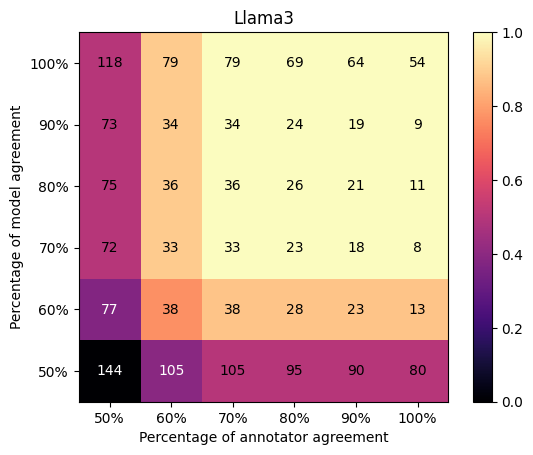

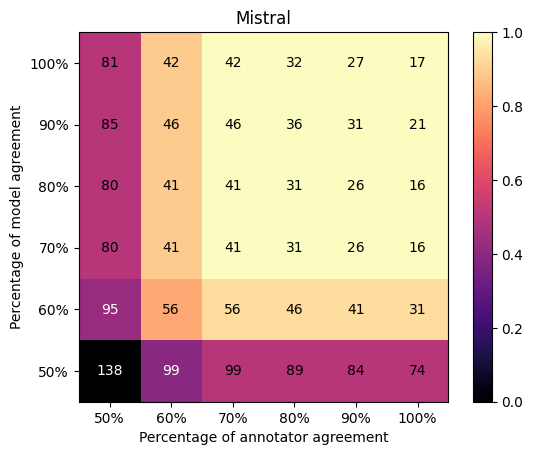

In [18]:
plot_matrix(ann_llama_matrix, ann_llama_f1s, 'Llama3')
plot_matrix(ann_mistral_matrix, ann_mistral_f1s, 'Mistral')

## 2. BERT f1 scores

## 2.1. Calculating

In [19]:
bert = pd.read_csv('../bert/predictions_bert_v1.csv')
paragraphs_df = pd.read_csv('../annotator_labels/paragraph_gold_annotator.csv')

In [20]:
paragraphs_df

,text-id,text,label,version,annotator_paragraph
0,medium-17,"Due to the overreach on the initial layoffs, c...",1,3,[1 1 1 1 1 1 1 0 1]
1,medium-17,I used to be in Pharmacy. Then I did a researc...,0,3,[1 0 0 0 1 1 0 0 0]
2,medium-17,So if a medical center has any that are partia...,1,3,[0 0 0 0 0 0 1 0 0]
3,medium-17,Open vials are supposed to be discarded after ...,1,3,[1 0 0 1 1 0 1 0 0]
4,medium-17,It costs about 15-35 cents to make a mL of ins...,1,3,[1 0 0 0 0 1 0 1 1]
...,...,...,...,...,...
157,hard-252,We don’t make more money today as land develop...,0,-1,NaN
158,hard-252,"Blame red tape, environmental “protection”, an...",1,-1,NaN
159,hard-252,If you want the government to intervene to mak...,1,-1,NaN
160,hard-252,Most politicians in my province (and probably ...,0,-1,NaN


In [21]:
bert.head()

,text-id,text,label,version,BERT predictions
0,medium-17,"Due to the overreach on the initial layoffs, c...",1,3,1
1,medium-17,I used to be in Pharmacy. Then I did a researc...,0,3,0
2,medium-17,So if a medical center has any that are partia...,1,3,0
3,medium-17,Open vials are supposed to be discarded after ...,1,3,0
4,medium-17,It costs about 15-35 cents to make a mL of ins...,1,3,0


In [22]:
df['ann_majority'] = df.apply(lambda row: row['labels'] if row['annotators_percentage'] >= 0.5 else 1 - row['labels'], axis=1)

bert

,text-id,text,label,version,BERT predictions
0,medium-17,"Due to the overreach on the initial layoffs, c...",1,3,1
1,medium-17,I used to be in Pharmacy. Then I did a researc...,0,3,0
2,medium-17,So if a medical center has any that are partia...,1,3,0
3,medium-17,Open vials are supposed to be discarded after ...,1,3,0
4,medium-17,It costs about 15-35 cents to make a mL of ins...,1,3,0
...,...,...,...,...,...
161,hard-862,"Well, I still don’t have an answer. I have opt...",0,6,0
162,hard-862,"Same here, others too. I don’t consider email ...",1,6,1
163,hard-862,After months of email going to spam I finally ...,1,6,0
164,hard-862,Receiving the same e-mails from Cedars trying ...,0,6,0


In [23]:
set(bert['text-id'].unique()) - set(df['text_ids'].unique())

{'hard-784'}

In [24]:
rows_to_drop = bert['text-id'] == 'hard-784'

bert = bert[~rows_to_drop]
bert.loc[bert['text-id'] == 'medium-277']
bert_filtered = bert.drop([38,39])

bert_filtered.loc[bert_filtered['text-id'] == 'medium-277']

,text-id,text,label,version,BERT predictions
40,medium-277,"Most bank statements, apps, etc. will have pho...",1,7,1
41,medium-277,When you can not get that form filled out (for...,1,7,0
42,medium-277,If your handwritten checks do not show how muc...,0,7,0


In [25]:
df

,text_ids,labels,annotators_percentage,llama_percentage,mistral_percentage,ann_majority
0,medium-17,1,0.888889,0.333333,1.000000,1
1,medium-17,0,0.666667,0.000000,0.222222,0
2,medium-17,1,0.111111,1.000000,0.888889,0
3,medium-17,1,0.444444,0.888889,0.333333,0
4,medium-17,1,0.444444,0.000000,0.444444,0
...,...,...,...,...,...,...
152,hard-862,0,0.571429,0.714286,0.714286,0
153,hard-862,1,0.714286,0.000000,0.571429,1
154,hard-862,1,0.428571,0.000000,0.857143,0
155,hard-862,0,0.000000,0.000000,0.142857,1


In [26]:
ranges = {
    '50': ([], [], []),
    '60': ([], [], []),
    '70': ([], [], []),
    '80': ([], [], []),
    '90': ([], [], []),
    '100': ([], [], [])
}

# Iterate over the DataFrame and assign each row to the appropriate range
for (gold, ann_label, percentage), bert_label in zip(df[['labels', 'ann_majority', 'annotators_percentage']].to_numpy(), bert_filtered['BERT predictions'].to_numpy()):
    percentage = percentage * 100  # Convert to percentage
    for range_key in ranges.keys():
        if range_key == '50':
            lower = 0
            upper = 50
        else:
            lower = int(range_key) - 10
            upper = int(range_key)
        if lower <= percentage < upper:
            ranges[range_key][0].append(int(gold))
            ranges[range_key][1].append(int(ann_label))
            ranges[range_key][2].append(int(bert_label))
            break
        if int(range_key) == 100:
            ranges[range_key][0].append(int(gold))
            ranges[range_key][1].append(int(ann_label))
            ranges[range_key][2].append(int(bert_label))


In [27]:
f1_scores = {}
for range_key, (gold_labels, ann_labels, bert_labels) in ranges.items():
    if gold_labels:  # Check if the range has any labels
        f1_gold_ann = f1_score(gold_labels, ann_labels)
        f1_gold_bert = f1_score(gold_labels, bert_labels)
        f1_scores[range_key] = {'gold_vs_ann': f1_gold_ann, 'gold_vs_bert': f1_gold_bert}

f1_scores

{'50': {'gold_vs_ann': 0.0, 'gold_vs_bert': 0.5507246376811594},
 '60': {'gold_vs_ann': 1.0, 'gold_vs_bert': 0.6666666666666666},
 '70': {'gold_vs_ann': 1.0, 'gold_vs_bert': 0.6},
 '80': {'gold_vs_ann': 1.0, 'gold_vs_bert': 0.7692307692307693},
 '90': {'gold_vs_ann': 1.0, 'gold_vs_bert': 0.7777777777777778},
 '100': {'gold_vs_ann': 1.0, 'gold_vs_bert': 0.5}}

## 2.2. Results

In [28]:
df_dict = {
    'range': [],
    'number_samples': [],
    'annotators' : [],
    'bert': []
}
for range_key, f1s in ranges.items():
    df_dict['range'].append(int(range_key))
    df_dict['annotators'].append(f1_scores[range_key]['gold_vs_ann'])
    df_dict['number_samples'].append(len(ranges[range_key][0]))
    df_dict['bert'].append(f1_scores[ range_key]['gold_vs_bert'])

f1_df = pd.DataFrame(df_dict)
f1_df

,range,number_samples,annotators,bert
0,50,67,0.0,0.550725
1,60,28,1.0,0.666667
2,70,28,1.0,0.600000
3,80,18,1.0,0.769231
4,90,13,1.0,0.777778
5,100,3,1.0,0.500000
